# Kernel Based methods for numerical solutions to PDEs: Symmetric and Unsymmetric Collocation

## At first: Generating Collocation- and Error Evaluation Points

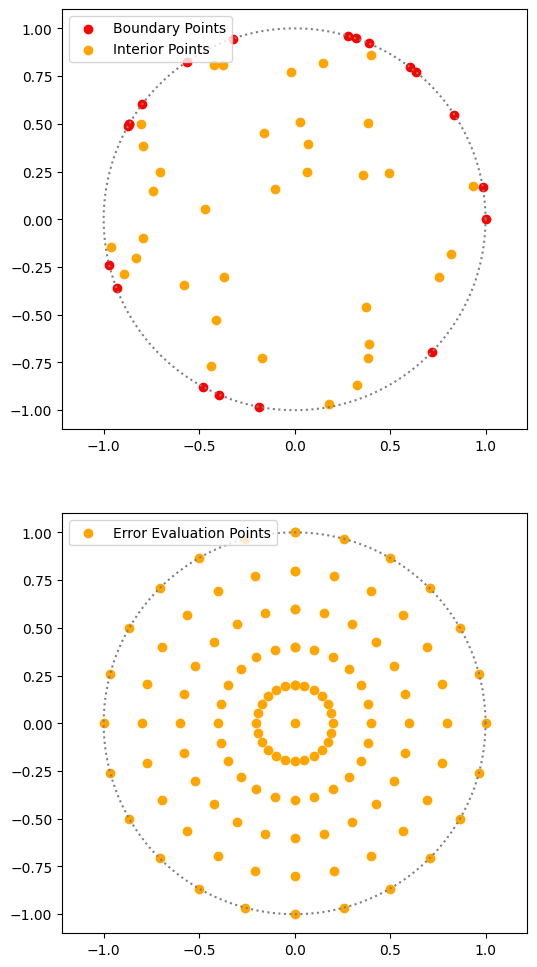

In [20]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sy
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

# to draw the unit circle
dat = np.linspace(0, 2*np.pi,200)
x = np.cos(dat)
y = np.sin(dat)

# sampling boundary points
n_bdy = 20
dat = np.random.uniform(0,2*np.pi, n_bdy)
bdy_x = np.cos(dat)
bdy_y = np.sin(dat)
bdy_coo = np.row_stack([bdy_x,bdy_y]) # coordinates of boundary points

# sampling interior points
n_int = 30
int_x = np.random.uniform(-1,1, np.ceil(n_int*np.pi/2).astype(int))
int_y = np.random.uniform(-1,1, np.ceil(n_int*np.pi/2).astype(int))
int_coo = np.row_stack([int_x,int_y]) # coordinates of interior points
int_norm = np.linalg.norm(int_coo, axis=0)
coo_norm = np.row_stack([int_coo,int_norm])

# delete points with norm greater than 1
indices = [i for (i,v) in enumerate(coo_norm[2]) if v>=1]
coo_norm = np.delete(coo_norm, indices, 1)
int_coo = coo_norm[:-1,:] # coordinates of interior points (cleared from exterior points)

# combine interior and boundary coordinates
coo = np.row_stack([int_coo.T, bdy_coo.T])

# Create error evaluation points
errd = np.array([[0, 0]])
theta = np.linspace(0, 2*np.pi, 25)
for i in range(5):
    x_err = np.sin(theta) * 1/5 * (i + 1)
    y_err = np.cos(theta) * 1/5 * (i + 1)
    d = [[x_err, y_err]]
    errd = np.append(errd, np.transpose(d).reshape((25, 2)), axis = 0)

# plot a figure with center points of radial basis functions and error evaluation points
f, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 12))

ax1.plot(x, y, linestyle=':', color='gray')
ax1.scatter(bdy_x,bdy_y, color='red', label = 'Boundary Points')
ax1.scatter(coo_norm[0],coo_norm[1], color='orange', label = 'Interior Points')
ax1.legend(loc='upper left')
ax1.axis('equal')

ax2.plot(x, y, linestyle=':', color= 'gray')
ax2.scatter(errd.T[0], errd.T[1], color= 'orange', label = 'Error Evaluation Points')
ax2.axis('equal')
ax2.legend(loc='upper left')

plt.show()

## Method 1: Asymmetric Colloctation
### Implement the radial basis function (Phi), the exact solution (u1) and their Laplacians

In [21]:
# Symbolic Version of phi
x, y, e, r = sy.symbols('x,y,e, r')
rbf = sy.sqrt(1+(e * sy.sqrt(x**2+y**2) )**2)
print("\n", "Phi: ")
sy.pprint(rbf)

# Symbolic version of the Laplacian of phi
drbf_x_x = sy.diff(rbf,x, 2)
drbf_y_y = sy.diff(rbf,y, 2)
L_rbf = sy.simplify(drbf_x_x + drbf_y_y)
print("\n", "The Laplacian of phi: ")
sy.pprint(L_rbf)

# Based on the results yielded by sympy above: Define rbf and L_rbf as functions of the RADIUS R (and shape parameter e)
rbf = sy.sqrt(1+(e*r)**2)
L_rbf = e**2*(((e*r)**2)+2) / (((e*r)**2)+1)**(3/2)

# Turn the symbolic functions rbf and L_rbd into CALLABLE functions
rbf = sy.utilities.lambdify((r,e), rbf)
rbf = np.vectorize(rbf)
L_rbf = sy.utilities.lambdify((r,e), L_rbf)
L_rbf = np.vectorize(L_rbf)

# The exact solution (symbolic)
u1 = 65 / (65+(x-0.2)**2+(y+0.1)**2)
du1_x_x = sy.diff(u1,x,2)
du1_y_y = sy.diff(u1,y,2)

# Turn the exact solution from a symbolic into a CALLABLE function
u1 = sy.utilities.lambdify((x, y), u1)
u1 = np.vectorize(u1)
Lu1 = sy.utilities.lambdify((x, y), du1_x_x + du1_y_y)
Lu1 = np.vectorize(Lu1)

# This is a alternate version of u1, which can take as argument an array with two collumns (u1 can only gake to floats as input). We need this just for
# technical reasons, i.e. such that our code below will run correctly. For the interpretation, u1_ equals u1.
def u1_(a):
    r = u1(a[0],a[1])
    return r


 Phi: 
   __________________
  ╱  2 ⎛ 2    2⎞     
╲╱  e ⋅⎝x  + y ⎠ + 1 

 The Laplacian of phi: 
 2 ⎛ 2  2    2  2    ⎞
e ⋅⎝e ⋅x  + e ⋅y  + 2⎠
──────────────────────
                   3/2
⎛ 2  2    2  2    ⎞   
⎝e ⋅x  + e ⋅y  + 1⎠   


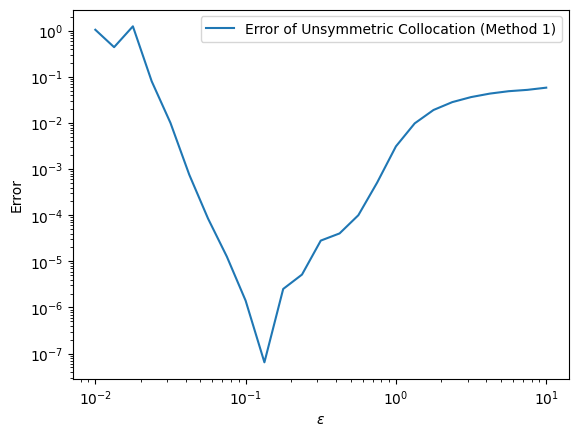

In [27]:
# Compute spatial distance matrices
dm_bdy = sc.spatial.distance_matrix(bdy_coo.T, np.append(int_coo, bdy_coo, axis= 1).T)
#print("\n", "dm_bdy: ", dm_bdy, np.shape(dm_bdy))
dm_int = sc.spatial.distance_matrix(int_coo.T, np.append(int_coo, bdy_coo,  axis= 1).T)
#print("\n", "dm_int: ", dm_int, np.shape(dm_int))

# This function sets up and solves the linear system of equations required for asymmetric collocation.
# The output is the lamda vector containing weights for each component of the basis of radial functions
def lam_calc_1(dm_int,dm_bdy,eps):
    ## Compile the coefficient Matrix
    ## for interior points
    mat_int = L_rbf(dm_int, eps)  # e= 0.1
    ## for the boundary
    mat_bdy = rbf(dm_bdy, eps)  # e= 0.1

    M = np.row_stack([mat_int, mat_bdy])

    ## Compile the right hand side
    r_int = Lu1(int_coo[0], int_coo[1])
    ## for the boundary
    r_bdy = u1(bdy_coo[0], bdy_coo[1])
    ## for interior poitns
    r = np.concatenate((r_int, r_bdy), axis=0)

    lam = sc.linalg.solve(M, r)
    return lam

# This function evaluates our approximate solution at the coordinates "eval_point", given a lambda vector (output of the function above), as
# well as a grid of center points an a shape parameter eps.
def u1_app1_rbf(eval_point,center_points,lam,eps):
    dv = sc.spatial.distance_matrix(np.array([eval_point]), center_points)
    rbf_dv = rbf(dv,eps)
    sol = np.dot(rbf_dv, lam)
    return sol

# This function evaluates the approximation error between the approximation (u1_app1_rbf) and the exact solution (func_true)
def error(u1_app1_rbf, func_true, errd, eps): # Argumnts: approximating solution, true solution, error evaluation points, epsilon
    lam = lam_calc_1(dm_int,dm_bdy, eps)
    app_sol = np.apply_along_axis(u1_app1_rbf, 1, errd, coo, lam, eps).flatten() # approximative solution
    sol = np.apply_along_axis(func_true, 1, errd) # exact solution
    error = np.max(abs(app_sol-sol))
    return error

# We want to evaluate the error over 25 different values ranging from 10^-2 to 10^1
eps_array = np.geomspace(1e-2, 1e1, 25)

# First round of the iteration over all 25 values of epsilon
error_array = np.array([eps_array[0], error(u1_app1_rbf,u1_,errd,eps_array[0])]).reshape(1,2)

# Starting with second round
for eps in eps_array[1:]:
    err = []
    #print("eps: ", eps)
    err = error(u1_app1_rbf, u1_, errd, eps)
    error_array = np.append(error_array, np.array([eps, err]).reshape(1, 2), axis=0)
    #print("error_array: ", error_array, np.shape(error_array), type(error_array))


plt.plot(error_array.T[0], error_array.T[1], label = "Error of Unsymmetric Collocation (Method 1)")
plt.xlabel('$\epsilon$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.show()

## Plotting the results: u1, L_u1 (the Laplacian of u1) and the approximative solution yielded by the first method

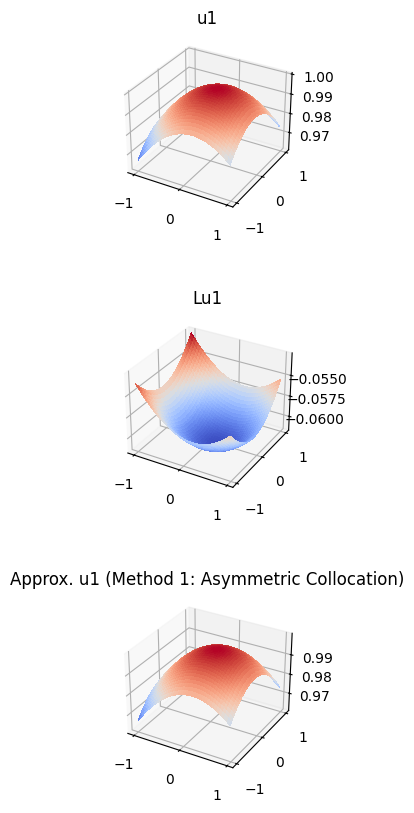

In [28]:
X = np.arange(-1, 1, 0.025)
Y = np.arange(-1, 1, 0.025)
X, Y = np.meshgrid(X, Y)
Z = u1(X,Y)
LZ = Lu1(X,Y)

plot_coo = np.vstack([X.ravel(), Y.ravel()]).T
eps = 0.1
lam = lam_calc_1(dm_int,dm_bdy,eps)
AZ = np.apply_along_axis(u1_app1_rbf, 1, plot_coo, coo, lam, eps).flatten().reshape(80,80)  # approximative solution

fig = plt.figure(figsize=(5, 8))

ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_title("u1")

ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax2.plot_surface(X, Y, LZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title("Lu1")

ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax3.plot_surface(X, Y, AZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax3.set_title("Approx. u1 (Method 1: Asymmetric Collocation)")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.show()

## Method 2: Symmetric Collocation
### Implement the radial basis function (Phi), the exact solution (u1) and their Laplacians

In [29]:
# Again, Symbolic Version of phi
x, y, e, r = sy.symbols('x,y,e,r')
rbf = sy.sqrt(1+(e * sy.sqrt(x**2+y**2) )**2)
print("\n", "Phi: ")
sy.pprint(rbf)

# Laplace Operator Applied Once
drbf_x_x = sy.diff(rbf,x, 2)
drbf_y_y = sy.diff(rbf,y, 2)
L_rbf = sy.simplify(drbf_x_x + drbf_y_y)
print("\n", "The Laplacian of phi: ")
sy.pprint(L_rbf)

# Second Application of Laplace Operator
dL_rbf_x_x = sy.diff(L_rbf,x,2)
dL_rbf_y_y = sy.diff(L_rbf,y,2)
L2_rbf = sy.simplify(dL_rbf_x_x + dL_rbf_y_y)
print("\n", "Laplacian operator applied to phi twice: ")
sy.pprint(L2_rbf)

# Based on the results yielded by sympy above: Define rbf and L_rbf as functions of the RADIUS R (and shape parameter e)
rbf = sy.sqrt(1+(e*r)**2)
L_rbf = e**2*(((e*r)**2)+2) / (((e*r)**2)+1)**(3/2)
L2_rbf = sy.simplify(L2_rbf.subs(x,(sy.sqrt(r**2-y**2)))) # replace x by sqrt(r^2-y^2)
L2_rbf = sy.simplify(L2_rbf.subs(y,(sy.sqrt(r**2-x**2)))) # replace x by sqrt(r^2-x^2)

# Again,turn the exact solution from a symbolic into a CALLABLE function
rbf = sy.utilities.lambdify((r,e), rbf)
rbf = np.vectorize(rbf)
L_rbf = sy.utilities.lambdify((r,e), L_rbf)
L_rbf = np.vectorize(L_rbf)
L2_rbf = sy.utilities.lambdify((r,e), L2_rbf)
L2_rbf = np.vectorize(L2_rbf)

# Again, we need an version of u1, which can take as argument an array with two collumns (u1 can only gake to floats as input). We need this just for
# technical reasons, i.e. such that our code below will run correctly. For the interpretation, u1_ equals u1.
def u1_(a):
    r = u1(a[0],a[1])
    return r


 Phi: 
   __________________
  ╱  2 ⎛ 2    2⎞     
╲╱  e ⋅⎝x  + y ⎠ + 1 

 The Laplacian of phi: 
 2 ⎛ 2  2    2  2    ⎞
e ⋅⎝e ⋅x  + e ⋅y  + 2⎠
──────────────────────
                   3/2
⎛ 2  2    2  2    ⎞   
⎝e ⋅x  + e ⋅y  + 1⎠   

 Laplacian operator applied to phi twice: 
                                  4 ⎛ 4  4      4  2  2    4  4      2  2     
                                 e ⋅⎝e ⋅x  + 2⋅e ⋅x ⋅y  + e ⋅y  + 8⋅e ⋅x  + 8⋅
──────────────────────────────────────────────────────────────────────────────
   ___________________                                                        
  ╱  2  2    2  2      ⎛ 6  6      6  4  2      6  2  4    6  6      4  4     
╲╱  e ⋅x  + e ⋅y  + 1 ⋅⎝e ⋅x  + 3⋅e ⋅x ⋅y  + 3⋅e ⋅x ⋅y  + e ⋅y  + 3⋅e ⋅x  + 6⋅

 2  2    ⎞                                 
e ⋅y  - 8⎠                                 
───────────────────────────────────────────
                                           
 4  2  2      4  4      2  2      2  2    ⎞
e ⋅x ⋅y  + 3⋅e ⋅y  + 3⋅e

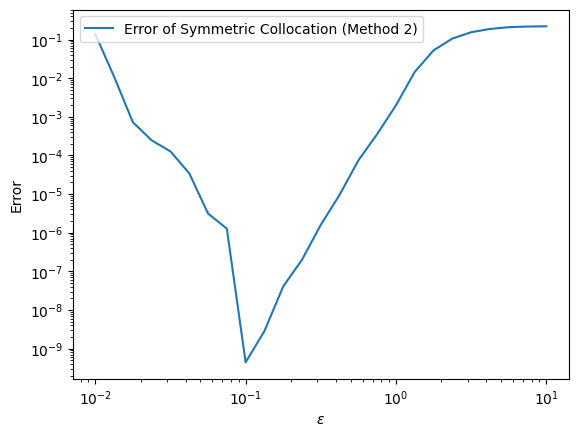

In [30]:
# Compute spatial distance matrices
dm_bdy_bdy = sc.spatial.distance_matrix(bdy_coo.T, bdy_coo.T)
#print("\n", "dm_bdy_bdy: ", dm_bdy_bdy, np.shape(dm_bdy_bdy))
dm_bdy_int = sc.spatial.distance_matrix(bdy_coo.T, int_coo.T)
#print("\n", "dm_bdy_int: ", dm_bdy_int, np.shape(dm_bdy_int))
dm_int_bdy = sc.spatial.distance_matrix(int_coo.T, bdy_coo.T)
#print("\n", "dm_int_bdy: ", dm_int_bdy, np.shape(dm_int_bdy))
dm_int_int = sc.spatial.distance_matrix(int_coo.T, int_coo.T)
#print("\n", "dm_int_int: ", dm_int_int, np.shape(dm_int_int))

# As with the first method, this function sets up and solves the linear system of equations required for symmetric collocation.
# The output is the lamda vector containing weights for each component of the basis of radial functions
def lam_calc_2(dm_bdy_bdy, dm_bdy_int, dm_int_bdy,dm_int_int,eps):
    ## Compile the coefficient Matrix
    mat_bdy_bdy = rbf(dm_bdy_bdy, eps)
    mat_bdy_int = L_rbf(dm_bdy_int, eps)
    mat_int_bdy = L_rbf(dm_int_bdy, eps)
    mat_int_int = L2_rbf(dm_int_int, eps)
    M = np.bmat([[mat_bdy_bdy,mat_bdy_int], [mat_int_bdy,mat_int_int]])

    ## Compile the right hand side
    ## for the boundary
    r_bdy = u1(bdy_coo[0], bdy_coo[1])
    ## for the  interior poitns
    r_int = Lu1(int_coo[0], int_coo[1])
    r = np.concatenate((r_bdy, r_int), axis=0)

    ## solve the system
    lam = sc.linalg.solve(M, r)
    return lam

# As before, this function evaluates our approximate solution at the coordinates "eval_point", given a lambda vector (output of the function above), as
# well as a grid of center points an a shape parameter eps.
def u1_app2_rbf(eval_point,center_points_int,center_points_bdy,lam,eps):

    dv_bdy = sc.spatial.distance_matrix(np.array([eval_point]), center_points_bdy)
    rbf_dv_bdy = rbf(dv_bdy, eps)

    dv_int = sc.spatial.distance_matrix(np.array([eval_point]), center_points_int)
    rbf_dv_int = L_rbf(dv_int, eps)

    rbf_dv = np.column_stack([rbf_dv_bdy,rbf_dv_int])
    sol = np.dot(rbf_dv, lam)
    return sol

# This function evaluates the approximation error between the approximation (u1_app2_rbf) and the exact solution (func_true)
def error(u1_app2_rbf, func_true, errd, eps): # Argumeents: approximating solution, true solution, error evaluation points, epsilon
    lam = lam_calc_2(dm_bdy_bdy, dm_bdy_int, dm_int_bdy,dm_int_int,eps)
    app_sol = np.apply_along_axis(u1_app2_rbf, 1, errd, int_coo.T, bdy_coo.T, lam, eps).flatten() # approximative solution
    sol = np.apply_along_axis(func_true, 1, errd) # exact solution
    error = np.max(abs(app_sol-sol))
    return error

# We want to evaluate the error over 25 different values ranging from 10^-2 to 10^1
eps_array = np.geomspace(1e-2, 1e1, 25)

# first round of the iteration across 25 values of epsilon
error_array = np.array([eps_array[0], error(u1_app2_rbf,u1_,errd,eps_array[0])]).reshape(1,2)

# Starting with second round
for eps in eps_array[1:]:
    err = []
    #print("eps: ", eps)

    err = error(u1_app2_rbf, u1_, errd, eps)
    error_array = np.append(error_array, np.array([eps, err]).reshape(1, 2), axis=0)
    #print("error_array: ", error_array, np.shape(error_array), type(error_array))

plt.plot(error_array.T[0], error_array.T[1], label = "Error of Symmetric Collocation (Method 2)")
plt.xlabel('$\epsilon$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper left')
plt.show()

## Again, plotting the results: u1, L_u1 (the Laplacian of u1) and the approximative solution yielded by the second method

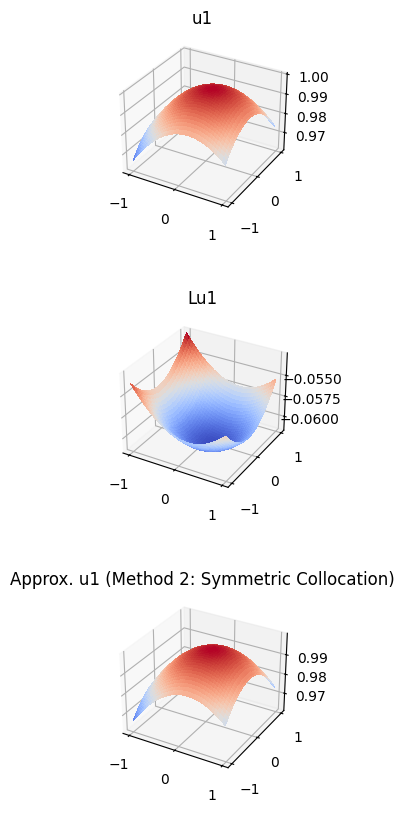

In [31]:
X = np.arange(-1, 1, 0.025)
Y = np.arange(-1, 1, 0.025)
X, Y = np.meshgrid(X, Y)
Z = u1(X,Y)
LZ = Lu1(X,Y)

plot_coo = np.vstack([X.ravel(), Y.ravel()]).T
eps = 0.1
lam = lam_calc_2(dm_bdy_bdy, dm_bdy_int, dm_int_bdy,dm_int_int,eps)
AZ = np.apply_along_axis(u1_app2_rbf, 1, plot_coo, int_coo.T, bdy_coo.T, lam, eps).flatten().reshape(80,80)  # approximative solution

fig = plt.figure(figsize=(5, 8))

ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_title("u1")

ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax2.plot_surface(X, Y, LZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title("Lu1")

ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax3.plot_surface(X, Y, AZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax3.set_title("Approx. u1 (Method 2: Symmetric Collocation)")
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.show()